# Import Dependancies

In [4]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

In [5]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kusuma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kusuma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kusuma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading and preprocessing

In [6]:
import gdown
import pandas as pd

# File ID from Google Drive
file_id = "16SI7Xz2XFYNmClqOPmCYyFRptlE7PqAQ"  # Replace with your actual File ID

# Construct Google Drive direct download URL
url = f"https://drive.google.com/uc?export=download&id=16SI7Xz2XFYNmClqOPmCYyFRptlE7PqAQ"

# Specify the output filename
dataset_path = "fake_reviews_dataset.csv"

# Download the file
gdown.download(url, dataset_path, quiet=False)

# Load the dataset
df = pd.read_csv(dataset_path)
print(df.head())  # Display the first 5 rows


Downloading...
From: https://drive.google.com/uc?export=download&id=16SI7Xz2XFYNmClqOPmCYyFRptlE7PqAQ
To: c:\Users\Kusuma\OneDrive\Desktop\Fake reviews detection system\fake_reviews_dataset.csv
100%|██████████| 15.3M/15.3M [00:06<00:00, 2.36MB/s]


             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  


In [7]:
df['label'].value_counts()

label
CG    20216
OR    20216
Name: count, dtype: int64

In [8]:
# Preprocessing functions
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [9]:
# Tokenize the text
df['tokens'] = df['text_'].apply(lambda x: x.split())

In [10]:
# Remove stopwords
df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [11]:
# Apply stemming
df['tokens_stemmed'] = df['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

In [12]:
# Join the tokens back into a string for cleaned text
df['cleaned_text'] = df['tokens_stemmed'].apply(lambda x: ' '.join(x))

In [13]:
df.head()

,category,rating,label,text_,tokens,tokens_no_stopwords,tokens_stemmed,cleaned_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...","[Love, this!, Well, made,, sturdy,, and, very,...","[Love, this!, Well, made,, sturdy,, comfortabl...","[love, this!, well, made,, sturdy,, comfortabl...","love this! well made, sturdy, comfortable. lov..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...","[love, it,, a, great, upgrade, from, the, orig...","[love, it,, great, upgrade, original., I've, m...","[love, it,, great, upgrad, original., i'v, min...","love it, great upgrad original. i'v mine coupl..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,"[This, pillow, saved, my, back., I, love, the,...","[pillow, saved, back., love, look, feel, pillow.]","[pillow, save, back., love, look, feel, pillow.]",pillow save back. love look feel pillow.
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...","[Missing, information, on, how, to, use, it,, ...","[Missing, information, use, it,, great, produc...","[miss, inform, use, it,, great, product, price!]","miss inform use it, great product price!"
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,"[Very, nice, set., Good, quality., We, have, h...","[nice, set., Good, quality., set, two, months]","[nice, set., good, quality., set, two, month]",nice set. good quality. set two month


# EDA with Sentiment Analyzer

In [14]:
# Initialize the SentimentIntensityAnalyzer (VADER)
sia = SentimentIntensityAnalyzer()

In [15]:
# Step 2: Perform sentiment analysis and categorize the sentiments
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)['compound']
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['cleaned_text'].apply(get_sentiment)

In [16]:
# Count the number of occurrences of each sentiment type
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

C:\Users\Kusuma\AppData\Local\Temp\ipykernel_34644\3270435995.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette='viridis')


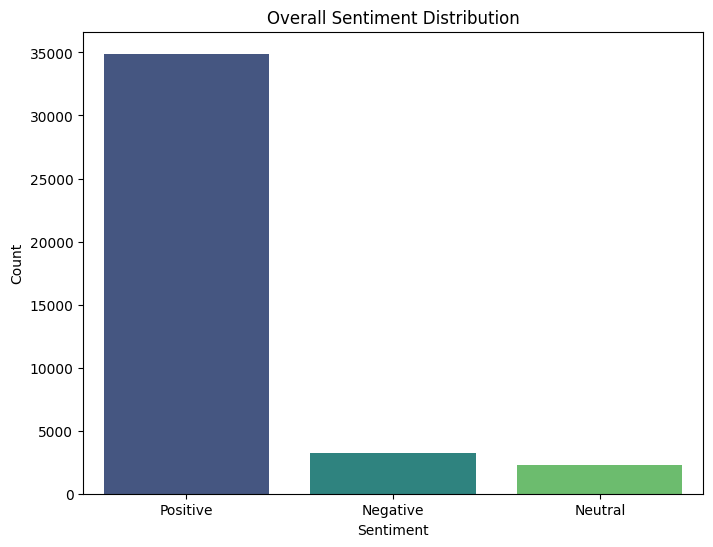

In [17]:
# Create a bar plot for overall sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette='viridis')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

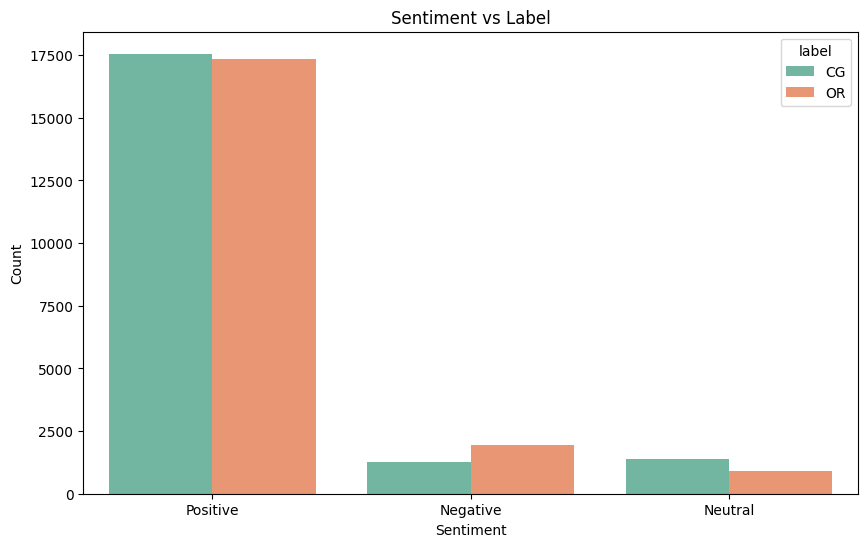

In [18]:
# If 'label' column contains categories, you can group by it
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', hue='label', data=df, palette='Set2')
plt.title('Sentiment vs Label')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Preparing the data for training

In [19]:
# Split the data into training and testing sets
X = df['cleaned_text']  # Feature (text data)
y = df['label']  # Target (label data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Training the Random Forest Classifier

In [21]:
# Train a classifier (Logistic Regression)
model = RandomForestClassifier()
model.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [22]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 83.26%

Classification Report:
              precision    recall  f1-score   support

          CG       0.82      0.86      0.84      6066
          OR       0.85      0.81      0.83      6064

    accuracy                           0.83     12130
   macro avg       0.83      0.83      0.83     12130
weighted avg       0.83      0.83      0.83     12130



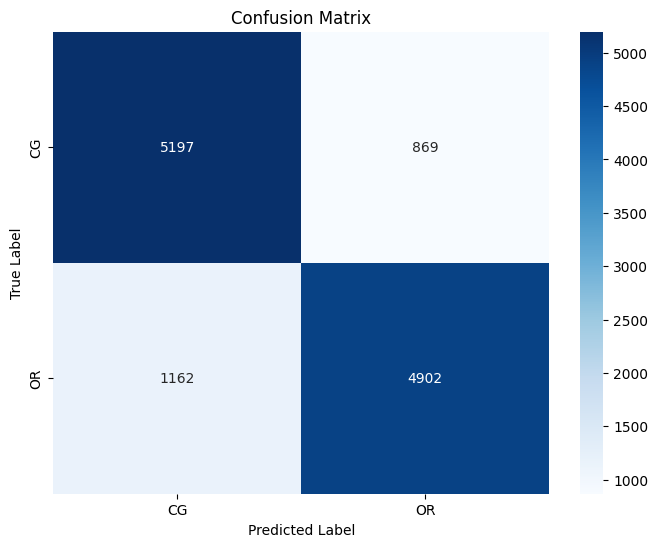

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
import joblib

# Save model
joblib.dump(model, 'random_forest_model.pkl')

# Save vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']